In [1]:
import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import bte

This notebook refines the multinomial model to enable better detection of MOV signal from BTE-inferred nodes using the global UShER tree with updated samples.
Here, we use Australia and France as external anchors for MOV enriched and non-MOV enriched respectively.
Outputs for the best thresholds of sum_llrs and sum_contexts are plotted below, supported by both proportional and absolute differences in node counts.

In [3]:
tree = bte.MATree(pb_file = "/Users/reem/final_tree.pb")
bte_df = pd.read_csv("/Users/reem/bte_nodes_with_sumllrs.tsv", sep="\t")
bte_df.head()


Finished 'from_pb' in 88.7221 seconds


,node_id,parent_id,children,mutations,num_mutations,level,branch_length,subs,Counts,LLR,...,spectrum,GtoA_counts,G>A_llr,AtoG_counts,A>G_llr,CtoT_counts,C>T_llr,TtoC_counts,T>C_llr,sum_llrs
0,CHN/YN-0306-466/2020|MT396241.1|2020-03-06,node_1,[],'G15910T',1,2,1.0,G>T,{'G>T': 1},-1.509730,...,T[G>T]A,Counter(),0.0,Counter(),0.0,Counter(),0.000000,Counter(),0.000000,-1.509730
1,DP0803|LC571037.1|2020-02-17,node_1,[],'G4162T',1,2,1.0,G>T,{'G>T': 1},-1.509730,...,T[G>T]G,Counter(),0.0,Counter(),0.0,Counter(),0.000000,Counter(),0.000000,-1.509730
2,node_2,node_1,['England/LEED-2A8B52/2020|OA971832.1|2020-04-...,'T13090C',1,2,1.0,T>C,{'T>C': 1},-0.528901,...,A[T>C]G,Counter(),0.0,Counter(),0.0,Counter(),0.000000,Counter({'A[T>C]G': 1}),-0.310864,-0.839765
3,England/LEED-2A8B52/2020|OA971832.1|2020-04-04,node_2,[],"'C1191T', 'C11674T'",2,3,2.0,"C>T,C>T",{'C>T': 2},0.872360,...,"C[C>T]A,A[C>T]T",Counter(),0.0,Counter(),0.0,"Counter({'C[C>T]A': 1, 'A[C>T]T': 1})",-0.267798,Counter(),0.000000,0.604561
4,England/SHEF-C06CE/2020|OY362267.1|2020-03-25,node_2,[],'T15821C',1,3,1.0,T>C,{'T>C': 1},-0.528901,...,A[T>C]G,Counter(),0.0,Counter(),0.0,Counter(),0.000000,Counter({'A[T>C]G': 1}),-0.310864,-0.839765


In [4]:
bte_df["LLR"].describe()        # I've used the wrong column for the this analysis here becaue I'm an idiot


count    8.906970e+06
mean    -3.753298e-01
std      1.215219e+00
min     -8.758536e+01
25%     -1.104265e+00
50%     -9.272124e-02
75%      4.361798e-01
max      1.965441e+01
Name: LLR, dtype: float64

In [5]:
cols = ['G>A_llr','A>G_llr','C>T_llr','T>C_llr',]
bte_df["sum_contexts"] = bte_df[cols].fillna(0).sum(axis=1)
bte_df["sum_contexts"]

0          0.000000
1          0.000000
2         -0.310864
3         -0.267798
4         -0.310864
             ...   
8906965   -1.370392
8906966   -1.036078
8906967    0.138013
8906968    0.766682
8906969   -0.368958
Name: sum_contexts, Length: 8906970, dtype: float64

In [6]:
bte_df["sum_contexts"].describe()

count    8.906970e+06
mean    -1.013543e-01
std      5.074346e-01
min     -9.789722e+00
25%     -3.602479e-01
50%      0.000000e+00
75%      1.380128e-01
max      2.582380e+01
Name: sum_contexts, dtype: float64

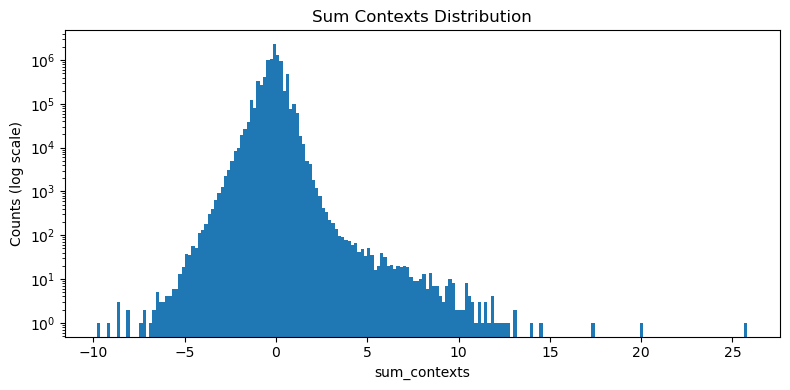

In [20]:
plt.figure(figsize=(8, 4))
plt.hist(bte_df["sum_contexts"], bins=200)
plt.yscale("log")
plt.xlabel("sum_contexts")
plt.ylabel("Counts (log scale)")
plt.title("Sum Contexts Distribution")
plt.tight_layout()
plt.show()



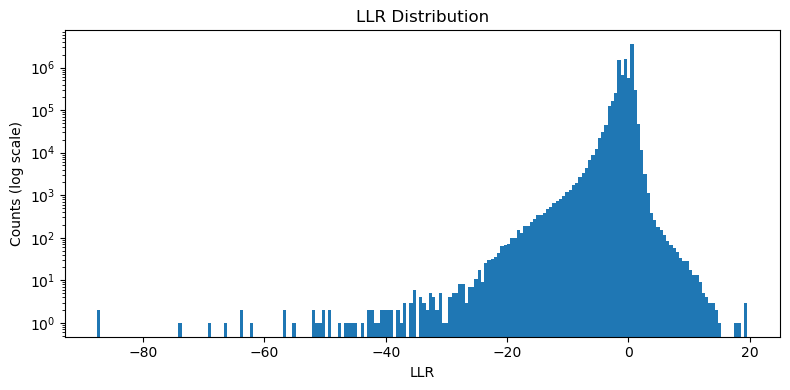

In [7]:
plt.figure(figsize=(8, 4))
plt.hist(bte_df["LLR"], bins=200)
plt.yscale("log")
plt.xlabel("LLR")
plt.ylabel("Counts (log scale)")
plt.title("LLR Distribution")
plt.tight_layout()
plt.show()



In [8]:
metafitch_out = pd.read_csv("/Users/reem/full_metafitch_output.tsv", sep="\t")
metafitch_out.head()

,strain,country,Year
0,node_1,"Philippines, Cote d'Ivoire, Viet Nam, Namibia,...",0
1,Guangzhou/GZ8H0013/2020|CNA0013706|2020-01-28,Unknown,2020
2,Guangzhou/GZ8H0014/2020|CNA0013707|2020-01-28,Unknown,2020
3,FRA/22022100202/2022|ON333670.1|2022-01-11,France,2022
4,USA/TX-CDC-ASC210033573/2021|MZ196053.1|2021-0...,USA,2021


In [23]:
len(metafitch_out)

21105850

In [9]:
metafitch_out.rename(columns={"strain":"node_id"}, inplace=True)
metafitch_out.head()

,node_id,country,Year
0,node_1,"Philippines, Cote d'Ivoire, Viet Nam, Namibia,...",0
1,Guangzhou/GZ8H0013/2020|CNA0013706|2020-01-28,Unknown,2020
2,Guangzhou/GZ8H0014/2020|CNA0013707|2020-01-28,Unknown,2020
3,FRA/22022100202/2022|ON333670.1|2022-01-11,France,2022
4,USA/TX-CDC-ASC210033573/2021|MZ196053.1|2021-0...,USA,2021


In [10]:
#Merge BTE data with Metafitch output
merged_df = pd.merge(bte_df, metafitch_out, left_on="node_id", right_on="node_id", how="inner")
len(merged_df)

8884126

In [11]:
merged_df.head()

,node_id,parent_id,children,mutations,num_mutations,level,branch_length,subs,Counts,LLR,...,AtoG_counts,A>G_llr,CtoT_counts,C>T_llr,TtoC_counts,T>C_llr,sum_llrs,sum_contexts,country,Year
0,CHN/YN-0306-466/2020|MT396241.1|2020-03-06,node_1,[],'G15910T',1,2,1.0,G>T,{'G>T': 1},-1.509730,...,Counter(),0.0,Counter(),0.000000,Counter(),0.000000,-1.509730,0.000000,China,2020
1,DP0803|LC571037.1|2020-02-17,node_1,[],'G4162T',1,2,1.0,G>T,{'G>T': 1},-1.509730,...,Counter(),0.0,Counter(),0.000000,Counter(),0.000000,-1.509730,0.000000,Unknown,2020
2,node_2,node_1,['England/LEED-2A8B52/2020|OA971832.1|2020-04-...,'T13090C',1,2,1.0,T>C,{'T>C': 1},-0.528901,...,Counter(),0.0,Counter(),0.000000,Counter({'A[T>C]G': 1}),-0.310864,-0.839765,-0.310864,England,2020
3,England/LEED-2A8B52/2020|OA971832.1|2020-04-04,node_2,[],"'C1191T', 'C11674T'",2,3,2.0,"C>T,C>T",{'C>T': 2},0.872360,...,Counter(),0.0,"Counter({'C[C>T]A': 1, 'A[C>T]T': 1})",-0.267798,Counter(),0.000000,0.604561,-0.267798,England,2020
4,England/SHEF-C06CE/2020|OY362267.1|2020-03-25,node_2,[],'T15821C',1,3,1.0,T>C,{'T>C': 1},-0.528901,...,Counter(),0.0,Counter(),0.000000,Counter({'A[T>C]G': 1}),-0.310864,-0.839765,-0.310864,England,2020


In [28]:
merged_df.to_csv("/Users/reem/merged_bte_metafitch.tsv", sep="\t", index=False)

In [12]:
df = merged_df[merged_df["country"].isin(["Australia", "France"])].copy()


In [13]:
df["country"].value_counts()


country
France       323210
Australia    122010
Name: count, dtype: int64

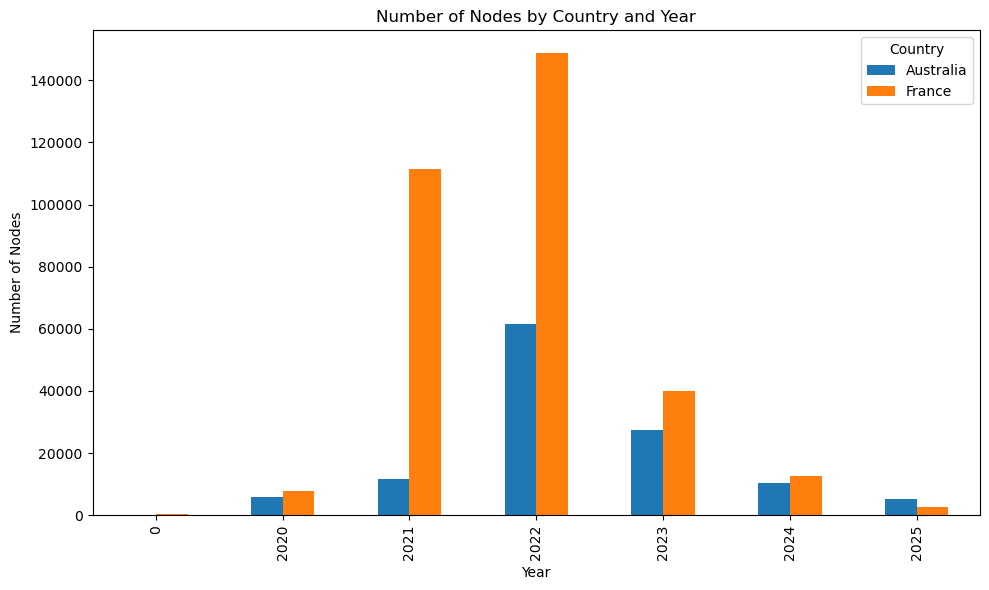

In [ ]:
# Number of sequenced genomes in Australia and France over the years
df.groupby("country")["Year"].value_counts().unstack().T.plot(kind="bar", figsize=(10, 6))
plt.xlabel("Year")
plt.ylabel("Number of Nodes")
plt.title("Number of Nodes by Country and Year")
plt.legend(title="Country")
plt.tight_layout()
plt.show()


In [15]:
df_2022 = df[
    (df["Year"] == 2022) &
    (df["country"].isin(["Australia", "France"]))
].copy()
df_2022.head()


,node_id,parent_id,children,mutations,num_mutations,level,branch_length,subs,Counts,LLR,...,AtoG_counts,A>G_llr,CtoT_counts,C>T_llr,TtoC_counts,T>C_llr,sum_llrs,sum_contexts,country,Year
165636,France/IDF-HMN-22032030368/2022|EPI_ISL_108985...,node_76726,[],"'T76A', 'T77A', 'T3730G', 'A6900C', 'G12434A',...",18,34,18.0,"T>A,T>A,T>G,A>C,G>A,C>A,G>T,T>G,T>A,T>G,A>C,T>...","{'T>A': 4, 'T>G': 3, 'A>C': 2, 'G>A': 1, 'C>A'...",-20.082052,...,Counter({'T[A>G]A': 1}),0.343645,Counter({'T[C>T]A': 1}),0.138013,Counter(),0.000000,-18.895462,1.186590,France,2022
358610,France/GES-HMN-22012100205/2022|EPI_ISL_907999...,node_167958,[],"'C1441T', 'T7328G', 'T27807C'",3,29,3.0,"C>T,T>G,T>C","{'C>T': 1, 'T>G': 1, 'T>C': 1}",-1.196986,...,Counter(),0.000000,Counter({'G[C>T]T': 1}),0.060484,Counter({'G[T>C]T': 1}),-0.181248,-1.317750,-0.120764,France,2022
358631,node_167971,node_167970,['Belgium/AZDelta-2200-03326/2022|EPI_ISL_8558...,'T26181C',1,28,1.0,T>C,{'T>C': 1},-0.528901,...,Counter(),0.000000,Counter(),0.000000,Counter({'T[T>C]T': 1}),0.545538,0.016637,0.545538,France,2022
358632,node_167972,node_167971,['France/IDF-ChSV-2220124345/2022|EPI_ISL_1115...,'T27513C',1,29,1.0,T>C,{'T>C': 1},-0.528901,...,Counter(),0.000000,Counter(),0.000000,Counter({'A[T>C]G': 1}),-0.310864,-0.839765,-0.310864,France,2022
358752,France/HDF-IPP10406/2022|EPI_ISL_10352750|2022...,node_168025,[],'C18555T',1,26,1.0,C>T,{'C>T': 1},0.436180,...,Counter(),0.000000,Counter({'A[C>T]A': 1}),0.346669,Counter(),0.000000,0.782849,0.346669,France,2022


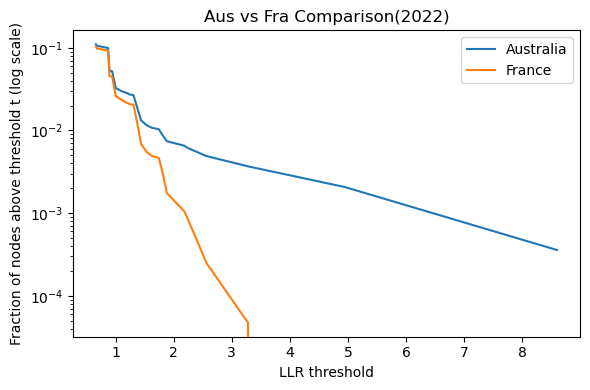

In [18]:
# Tail LLR survival comparison: Australia vs France (2022)
import numpy as np
import matplotlib.pyplot as plt

au = df_2022.loc[df_2022.country=="Australia", "LLR"].to_numpy()
fr = df_2022.loc[df_2022.country=="France", "LLR"].to_numpy()

thresholds = np.quantile(np.concatenate([au, fr]), np.linspace(0.9, 0.9999, 200))  # Gets the 90th to 99th percentiles of sum_llrs for both AU and FR and quantifies 200 thresholds within this range

au_surv = [(au >= t).mean() for t in thresholds]
fr_surv = [(fr >= t).mean() for t in thresholds]

plt.figure(figsize=(6,4))
plt.plot(thresholds, au_surv, label="Australia")
plt.plot(thresholds, fr_surv, label="France")
plt.yscale("log")
plt.xlabel("LLR threshold")
plt.ylabel("Fraction of nodes above threshold t (log scale)")
plt.title("Aus vs Fra Comparison(2022)")
plt.legend()
plt.tight_layout()
plt.show()


# Extreme mutation-pattern enrichment is more common in Australia in 2022
# Sum LLRs only enriched in Australia at extreme thresholds
# Now check contexts as well


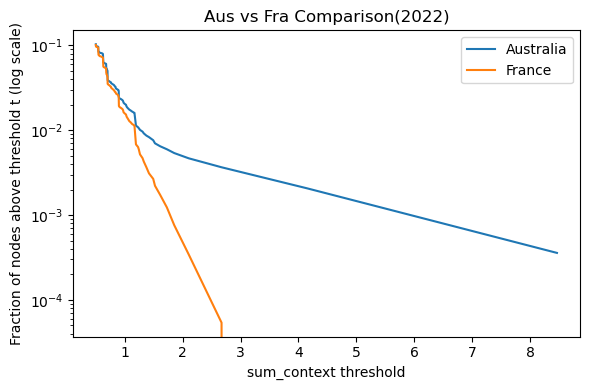

In [44]:
# Tail sum_contexts survival comparison: Australia vs France (2022)
import numpy as np
import matplotlib.pyplot as plt

au = df_2022.loc[df_2022.country=="Australia", "sum_contexts"].to_numpy()
fr = df_2022.loc[df_2022.country=="France", "sum_contexts"].to_numpy()

thresholds = np.quantile(np.concatenate([au, fr]), np.linspace(0.9, 0.9999, 200))  # Gets the 90th to 99th percentiles of sum_llrs for both AU and FR and quantifies 200 thresholds within this range

au_surv = [(au >= t).mean() for t in thresholds]
fr_surv = [(fr >= t).mean() for t in thresholds]

plt.figure(figsize=(6,4))
plt.plot(thresholds, au_surv, label="Australia")
plt.plot(thresholds, fr_surv, label="France")
plt.yscale("log")
plt.xlabel("sum_context threshold")
plt.ylabel("Fraction of nodes above threshold t (log scale)")
plt.title("Aus vs Fra Comparison(2022)")
plt.legend()
plt.tight_layout()
plt.show()

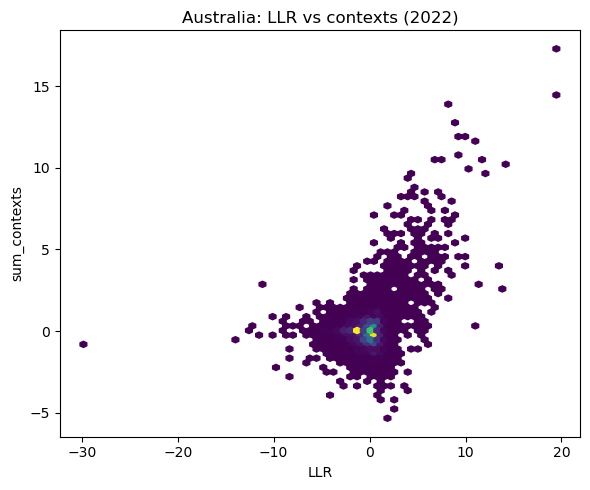

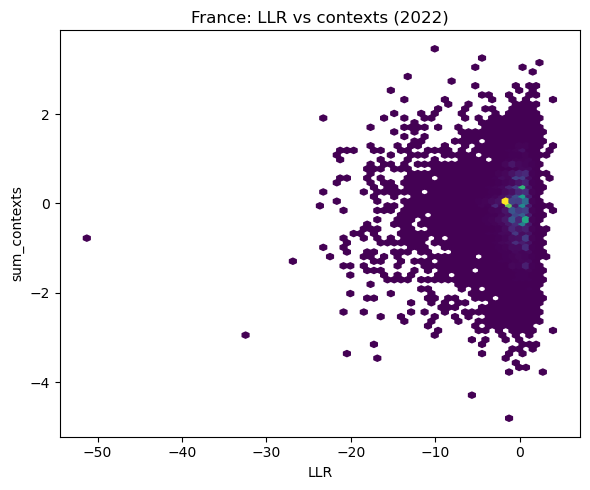

In [19]:
plt.figure(figsize=(6,5))
plt.hexbin(df_2022.loc[df_2022.country=="Australia","LLR"],
           df_2022.loc[df_2022.country=="Australia","sum_contexts"],
           gridsize=70, mincnt=1)
plt.xlabel("LLR"); plt.ylabel("sum_contexts")
plt.title("Australia: LLR vs contexts (2022)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,5))
plt.hexbin(df_2022.loc[df_2022.country=="France","LLR"],
           df_2022.loc[df_2022.country=="France","sum_contexts"],
           gridsize=70, mincnt=1)
plt.xlabel("LLR"); plt.ylabel("sum_contexts")
plt.title("France: LLR vs contexts (2022)")
plt.tight_layout(); plt.show()

# Australian nodes with strong MOV-like mutation patterns also accumulate context evidence. Also, Australia has many more nodes with extreme LLRs. High LLRs and high context co-occur.
# Extreme LLRs in France are rarer, and less consistently supported by context.


In [24]:
import plotly.figure_factory as ff
import plotly.express as px
import numpy as np

# Threshold sweep heatmap
LLR_thresh = [1,2,3,4,5,6,7,10,12]
sum_context_thresh = [1,2,3,4,5,6,7,10,12] 

# Create a grid to hold results
rows = []
for llr_t in LLR_thresh:
    for ctx_t in sum_context_thresh:
        Mov_pred = (df_2022["LLR"] > llr_t) & (df_2022["sum_contexts"] > ctx_t)
        rows.append({
            "LLR_thresh": llr_t,
            "sum_context_thresh": ctx_t,
            "Australia_counts": Mov_pred[df_2022["country"]=="Australia"].sum(),
            "France_counts": Mov_pred[df_2022["country"]=="France"].sum(),
            "contrast": Mov_pred[df_2022["country"]=="Australia"].sum() - Mov_pred[df_2022["country"]=="France"].sum()
        })
heatmap_df = pd.DataFrame(rows)
heatmap_pivot = heatmap_df.pivot(index="sum_context_thresh", columns="LLR_thresh", values="contrast")

# Plot heatmap
fig = px.imshow(heatmap_pivot,
                labels=dict(x="LLR_thresh", y="sum_context_thresh", color="contrast"),
                x=LLR_thresh,
                y=sum_context_thresh,
                text_auto="auto",
                aspect = "equal",
                title="Difference in MOV-like counts (Australia - France) in 2022")
fig.update_xaxes(constrain="domain")
fig.update_yaxes(autorange=True)
fig.update_layout(width=800, height=800)
fig.show()  
      


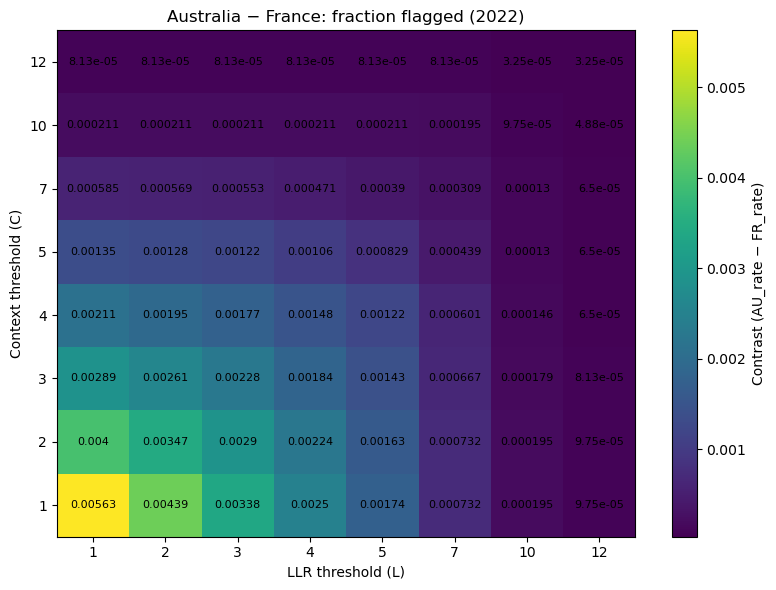

Top threshold pairs by contrast (with n_flagged_total >= 0):
 LLR  CTX  contrast  AU_rate  FR_rate  n_flagged_total  n_flagged_AU  n_flagged_FR
   1    1  0.005630 0.007218 0.001587              680           444           236
   2    1  0.004389 0.004503 0.000114              294           277            17
   1    2  0.003996 0.004097 0.000101              267           252            15
   2    2  0.003465 0.003479 0.000013              216           214             2
   3    1  0.003377 0.003398 0.000020              212           209             3
   3    2  0.002903 0.002910 0.000007              180           179             1
   1    3  0.002887 0.002894 0.000007              179           178             1
   2    3  0.002611 0.002617 0.000007              162           161             1
   4    1  0.002497 0.002503 0.000007              155           154             1
   3    3  0.002276 0.002276 0.000000              140           140             0


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

llr_grid = [1,2, 3, 4, 5, 7, 10, 12]
ctx_grid = [1,2, 3, 4, 5, 7, 10, 12]

rows = []
for L in llr_grid:
    for C in ctx_grid:
        mov_pred = (df_2022["LLR"] >= L) & (df_2022["sum_contexts"] >= C)

        au_mask = (df_2022["country"] == "Australia")
        fr_mask = (df_2022["country"] == "France")

        au_rate = mov_pred[au_mask].mean()
        fr_rate = mov_pred[fr_mask].mean()

        rows.append({
            "LLR": L,
            "CTX": C,
            "AU_rate": au_rate,
            "FR_rate": fr_rate,
            "contrast": au_rate - fr_rate,
            "n_flagged_total": int(mov_pred.sum()),
            "n_flagged_AU": int(mov_pred[au_mask].sum()),
            "n_flagged_FR": int(mov_pred[fr_mask].sum()),
        })

grid = pd.DataFrame(rows)

# --- 2) Heatmap matplotlib ---
def plot_heatmap(value_col, title, cbar_label):
    mat = grid.pivot(index="CTX", columns="LLR", values=value_col)

    plt.figure(figsize=(8, 6))
    plt.imshow(mat.values, origin="lower", aspect="auto")
    plt.colorbar(label=cbar_label)

    plt.xticks(range(len(mat.columns)), mat.columns)
    plt.yticks(range(len(mat.index)), mat.index)

    plt.xlabel("LLR threshold (L)")
    plt.ylabel("Context threshold (C)")
    plt.title(title)

    # annotate each cell with the value
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            v = mat.values[i, j]
            if pd.notna(v):
                # nicer formatting for different metrics
                txt = f"{v:.3g}" if value_col != "n_flagged_total" else f"{int(v)}"
                plt.text(j, i, txt, ha="center", va="center", fontsize=8)

    plt.tight_layout()
    plt.show()

# --- 3) Step 2: Contrast heatmap ---
plot_heatmap(
    value_col="contrast",
    title="Australia − France: fraction flagged (2022)",
    cbar_label="Contrast (AU_rate − FR_rate)"
)

# --- 4) Optional: print top candidates with a minimum count filter ---
min_flagged = 0
top = (grid[grid["n_flagged_total"] >= min_flagged]
       .sort_values("contrast", ascending=False)
       .head(10))

print("Top threshold pairs by contrast (with n_flagged_total >= {}):".format(min_flagged))
print(top[["LLR","CTX","contrast","AU_rate","FR_rate","n_flagged_total","n_flagged_AU","n_flagged_FR"]].to_string(index=False))


In [53]:
# Plot grouped barplot with thresholds LLR>2 and sum_contexts>2
rows = []
Years = [2020, 2021, 2022, 2023, 2024, 2025]

for year in Years:
    df_yr = df[df["Year"]==year]
    Mov_pred = (df_yr["LLR"] > 3) & (df_yr["sum_contexts"] > 2)
    rows.append({
        "Australia_counts": Mov_pred[df_yr["country"]=="Australia"].sum(),
        "France_counts": Mov_pred[df_yr["country"]=="France"].sum(),
        "year": year,
    })
plotly_df = pd.DataFrame(rows)  

fig = px.bar(plotly_df, x="year", y=["Australia_counts", "France_counts"],
             barmode = 'group')
fig.show()                                        

In [7]:
countries = ['Australia','France']
for t in thresholds:
    for country in countries:
        count = len(df[(df['sum_context'] > t) & (df['seqName'].str.contains(f"/{country}/"))])
        print(f"Number of sequences from {country} with sum_context > {t}: {count}")

Number of sequences from Australia with sum_context > 2: 1449
Number of sequences from France with sum_context > 2: 2877
Number of sequences from Australia with sum_context > 5: 197
Number of sequences from France with sum_context > 5: 4
Number of sequences from Australia with sum_context > 6: 151
Number of sequences from France with sum_context > 6: 1
Number of sequences from Australia with sum_context > 7: 103
Number of sequences from France with sum_context > 7: 0
Number of sequences from Australia with sum_context > 8: 75
Number of sequences from France with sum_context > 8: 0
Number of sequences from Australia with sum_context > 10: 24
Number of sequences from France with sum_context > 10: 0
Number of sequences from Australia with sum_context > 15: 7
Number of sequences from France with sum_context > 15: 0
Number of sequences from Australia with sum_context > 20: 6
Number of sequences from France with sum_context > 20: 0


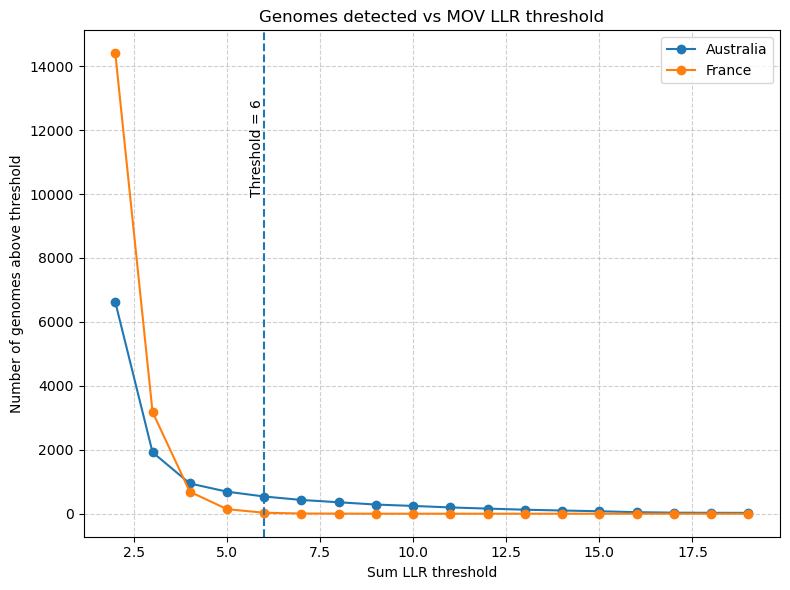

In [8]:

plt.figure(figsize=(8, 6))
thresholds = range(2, 20, 1)
australia_counts = [(df[df['country']=='Australia']['sum_llrs'] > t).sum() for t in thresholds]
france_counts = [(df[df['country']=='France']['sum_llrs'] > t).sum() for t in thresholds]

plt.plot(thresholds, australia_counts, marker="o", label="Australia")
plt.plot(thresholds, france_counts, marker="o", label="France")

# Highlight threshold = 6
plt.axvline(6, linestyle="--")
plt.text(6, max(max(australia_counts), max(france_counts))*0.9, "Threshold = 6", rotation=90, va="top", ha="right")

plt.xlabel("Sum LLR threshold")
plt.ylabel("Number of genomes above threshold")
plt.title("Genomes detected vs MOV LLR threshold")

plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


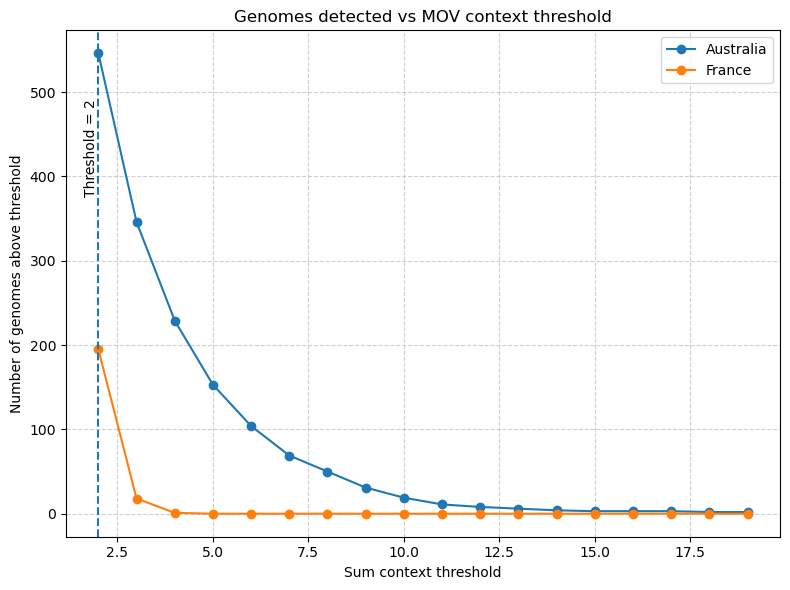

In [56]:

plt.figure(figsize=(8, 6))
thresholds = range(2, 20, 1)
australia_counts = [(df[df['country']=='Australia']['sum_contexts'] > t).sum() for t in thresholds]
france_counts = [(df[df['country']=='France']['sum_contexts'] > t).sum() for t in thresholds]

plt.plot(thresholds, australia_counts, marker="o", label="Australia")
plt.plot(thresholds, france_counts, marker="o", label="France")

# Highlight threshold = 6
plt.axvline(2, linestyle="--")
plt.text(2, max(max(australia_counts), max(france_counts))*0.9, "Threshold = 2", rotation=90, va="top", ha="right")

plt.xlabel("Sum context threshold")
plt.ylabel("Number of genomes above threshold")
plt.title("Genomes detected vs MOV context threshold")

plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

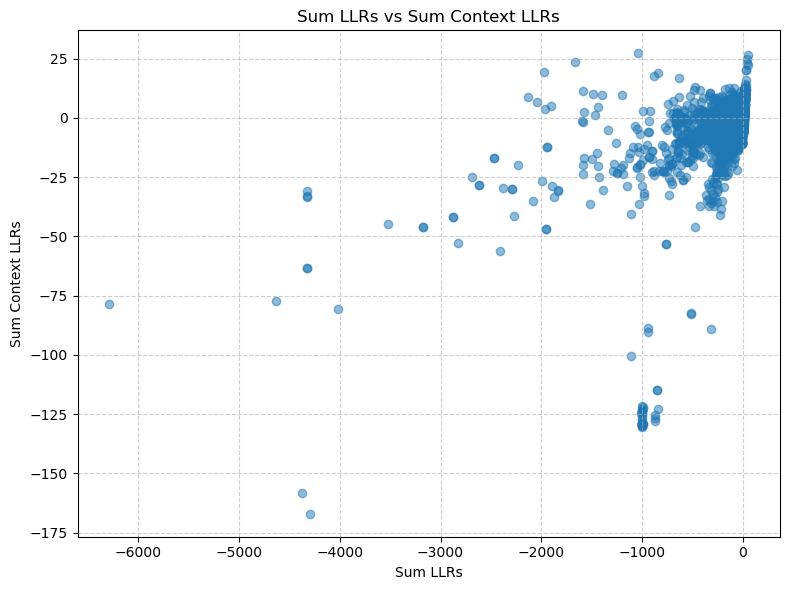

In [55]:
# Sum_llrs vs Sum_context plot
plt.figure(figsize=(8, 6))
plt.scatter(df['sum_llrs'], df['sum_context'], alpha=0.5)
plt.xlabel('Sum LLRs')
plt.ylabel('Sum Context LLRs')
plt.title('Sum LLRs vs Sum Context LLRs')
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [199]:
old = merged_df.loc[merged_df['sum_llrs'] > 6, 'node_id']
new = merged_df.loc[(merged_df['LLR'] > 3) & (merged_df['sum_contexts'] > 2), 'node_id']

print(len(old))
print(len(new))


1238
1024


In [ ]:
mov_df = merged_df[(merged_df['LLR'] > 3) & (merged_df['sum_contexts'] > 2)]   

mov_df.head()

is_singleton
False    1024
Name: count, dtype: int64

In [32]:
mov_df.to_csv("/Users/reem/mov_llr_context_3_2.tsv", sep="\t", index=False)